## Business Problem

A business receives raw sales data in CSV format on a regular basis. 
Currently, reporting is done manually by opening the file, calculating KPIs, 
and creating charts in Excel. This process is time-consuming, error-prone, 
and difficult to scale as data grows.

The goal of this project is to automate the generation of a simple sales 
performance report using Python, allowing stakeholders to receive 
consistent and reliable insights with minimal manual effort.

In [1]:
import pandas
import numpy
import os

## Report Spec (Automated Weekly Customer Health Report)

Goal: Turn Customer_Transactions.csv into a weekly summary that a business owner can read in 2 minutes.

Audience: Marketing/Retention Lead

Time window: Last 7 days (based on last_purchase_date)

Outputs:
1) KPIs table (overall)
2) KPI breakdowns (by country, gender, tier)
3) Trends charts (weekly)
4) At-risk customer list (top 50)
5) Data quality checks summary

## Step 1: Load Data & Define Reporting Window

In [2]:
# Load the customer transactions data
df = pandas.read_csv('../data/Customer_Transactions.csv')

# Convert date columns to datetime
df['last_purchase_date'] = pandas.to_datetime(df['last_purchase_date'])

# Define reporting window (last 30 days)
current_date = df['last_purchase_date'].max()
window_start = current_date - pandas.Timedelta(days=30)

print(f"Current Date: {current_date.date()}")
print(f"Window Start: {window_start.date()}")
print(f"Total Records: {len(df)}")

# Filter to last 30 days
df_window = df[df['last_purchase_date'] >= window_start].copy()
print(f"Records in 30-day window: {len(df_window)}")

Current Date: 2025-10-27
Window Start: 2025-09-27
Total Records: 10000
Records in 30-day window: 1559


## Step 2: Calculate Days Since Purchase

In [3]:
# Calculate days since last purchase
df_window['days_since_purchase'] = (current_date - df_window['last_purchase_date']).dt.days

print(f"Days Since Purchase Stats:")
print(df_window['days_since_purchase'].describe())

Days Since Purchase Stats:
count    1559.000000
mean       15.243746
std         8.942599
min         0.000000
25%         8.000000
50%        15.000000
75%        23.000000
max        30.000000
Name: days_since_purchase, dtype: float64


## Step 3: Identify At-Risk Customers (Top 50)

In [4]:
# Define at-risk criteria
at_risk_condition = (df_window['days_since_purchase'] >= 30) | (df_window['cart_abandon_rate'] >= 0.9)

# Filter at-risk customers
at_risk_customers = df_window[at_risk_condition].copy()

# Sort by days_since_purchase (desc), then cart_abandon_rate (desc)
at_risk_customers = at_risk_customers.sort_values(
    by=['days_since_purchase', 'cart_abandon_rate'], 
    ascending=[False, False]
)

# Select top 50 and specific columns
at_risk_top_50 = at_risk_customers.head(50)[
    ['customer_id', 'country', 'gender', 'days_since_purchase', 
     'cart_abandon_rate', 'num_purchases', 'avg_purchase_value', 'churned']
]

print(f"Total At-Risk Customers: {len(at_risk_customers)}")
print(f"\nTop 50 At-Risk Customers:")
print(at_risk_top_50)

Total At-Risk Customers: 184

Top 50 At-Risk Customers:
      customer_id       country  gender  days_since_purchase  \
3469         3470        Canada  Female                   30   
422           423            UK  Female                   30   
3759         3760     Australia    Male                   30   
9769         9770        Brazil    Male                   30   
6459         6460         India  Female                   30   
7421         7422       Germany    Male                   30   
5485         5486        Brazil    Male                   30   
4373         4374         India    Male                   30   
2672         2673       Germany  Female                   30   
9475         9476         Japan    Male                   30   
2609         2610       Germany  Female                   30   
637           638     Australia  Female                   30   
2199         2200           USA  Female                   30   
3389         3390        Canada    Male         

## Step 4: Build Overall KPI Table

In [11]:
# Calculate overall KPIs from the 30-day window
kpi_overall = pandas.DataFrame({
    'total_customers': [len(df_window)],
    'active_customers': [(df_window['churned'] == 0).sum()],
    'churned_customers': [(df_window['churned'] == 1).sum()],
    'churn_rate': [(df_window['churned'] == 1).sum() / len(df_window)],
    'avg_purchase_value': [df_window['avg_purchase_value'].mean()],
    'avg_website_visits_per_month': [df_window['website_visits_per_month'].mean()],
    'avg_cart_abandon_rate': [df_window['cart_abandon_rate'].mean()],
    'avg_days_since_purchase': [df_window['days_since_purchase'].mean()],
    'revenue_proxy': [(df_window['avg_purchase_value'] * df_window['num_purchases']).sum()]
})

print("Overall KPI Table (30-Day Window):")
print(kpi_overall)

Overall KPI Table (30-Day Window):
   total_customers  active_customers  churned_customers  churn_rate  \
0             1559              1559                  0         0.0   

   avg_purchase_value  avg_website_visits_per_month  avg_cart_abandon_rate  \
0           47.543919                     15.764593               0.484682   

   avg_days_since_purchase  revenue_proxy  
0                15.243746     1746819.17  


In [9]:
# Create output directory if it doesn't exist
os.makedirs('../output', exist_ok=True)

# Export KPI table to CSV
output_path = '../output/kpi_overall_30_days.csv'
kpi_overall.to_csv(output_path, index=False)
print(f"✓ KPI table exported to: {output_path}")

✓ KPI table exported to: ../output/kpi_overall_30_days.csv


In [10]:
# Generate summary text
churn_rate_pct = kpi_overall['churn_rate'].iloc[0] * 100
avg_abandon_rate_pct = kpi_overall['avg_cart_abandon_rate'].iloc[0] * 100

print(f"\n📊 Quick Summary:")
print(f"In the last 30 days, {churn_rate_pct:.1f}% of customers churned, with an average cart abandon rate of {avg_abandon_rate_pct:.1f}%.")


📊 Quick Summary:
In the last 30 days, 0.0% of customers churned, with an average cart abandon rate of 48.5%.


## Step 5: Create Customer Tier Segmentation

In [5]:
# Create customer tier based on spending_score
def categorize_tier(score):
    if score < 40:
        return 'Low'
    elif score <= 70:
        return 'Medium'
    else:
        return 'High'

df_window['customer_tier'] = df_window['spending_score'].apply(categorize_tier)

print("Customer Tier Distribution:")
print(df_window['customer_tier'].value_counts().sort_index())

Customer Tier Distribution:
customer_tier
High      488
Low       541
Medium    530
Name: count, dtype: int64


## Step 6: KPI Breakdown by Country

In [13]:
# Calculate KPI breakdown by country
kpi_by_country = df_window.groupby('country').agg(
    total_customers=('customer_id', 'count'),
    churn_rate=('churned', 'mean'),
    avg_cart_abandon_rate=('cart_abandon_rate', 'mean'),
    avg_days_since_purchase=('days_since_purchase', 'mean')
).reset_index()

# Sort by highest avg_cart_abandon_rate, then highest avg_days_since_purchase
kpi_by_country = kpi_by_country.sort_values(
    by=['avg_cart_abandon_rate', 'avg_days_since_purchase'],
    ascending=[False, False]
)

# Export to CSV
kpi_by_country.to_csv('../output/kpi_by_country_30_days.csv', index=False)
print("✓ KPI by Country exported to: ../output/kpi_by_country_30_days.csv")

print("\nTop 5 Countries by Risk:")
print(kpi_by_country.head())

✓ KPI by Country exported to: ../output/kpi_by_country_30_days.csv

Top 5 Countries by Risk:
     country  total_customers  churn_rate  avg_cart_abandon_rate  \
3     France               94         0.0               0.509043   
5      India              255         0.0               0.496431   
2     Canada              145         0.0               0.496138   
9        USA              349         0.0               0.484613   
0  Australia              116         0.0               0.483966   

   avg_days_since_purchase  
3                16.180851  
5                15.615686  
2                15.682759  
9                14.343840  
0                14.465517  


In [14]:
# Country insights
top_country = kpi_by_country.iloc[0]
print(f"\n💡 Insight: {top_country['country']} shows the highest cart abandon rate at {top_country['avg_cart_abandon_rate']:.1%}, with customers averaging {top_country['avg_days_since_purchase']:.1f} days since purchase.")


💡 Insight: France shows the highest cart abandon rate at 50.9%, with customers averaging 16.2 days since purchase.


## Step 7: KPI Breakdown by Customer Tier

In [6]:
# Calculate KPI breakdown by customer tier
kpi_by_tier = df_window.groupby('customer_tier').agg(
    total_customers=('customer_id', 'count'),
    churn_rate=('churned', 'mean'),
    avg_cart_abandon_rate=('cart_abandon_rate', 'mean'),
    avg_purchase_value=('avg_purchase_value', 'mean')
).reset_index()

# Sort by tier order (Low, Medium, High)
tier_order = {'Low': 0, 'Medium': 1, 'High': 2}
kpi_by_tier['sort_order'] = kpi_by_tier['customer_tier'].map(tier_order)
kpi_by_tier = kpi_by_tier.sort_values('sort_order').drop('sort_order', axis=1)

# Export to CSV
kpi_by_tier.to_csv('../output/kpi_by_tier_30_days.csv', index=False)
print("✓ KPI by Tier exported to: ../output/kpi_by_tier_30_days.csv")

print("\nKPI Breakdown by Customer Tier:")
print(kpi_by_tier)

✓ KPI by Tier exported to: ../output/kpi_by_tier_30_days.csv

KPI Breakdown by Customer Tier:
  customer_tier  total_customers  churn_rate  avg_cart_abandon_rate  \
1           Low              541         0.0               0.484880   
2        Medium              530         0.0               0.471340   
0          High              488         0.0               0.498955   

   avg_purchase_value  
1           41.262015  
2           47.784868  
0           54.246393  


In [16]:
# Tier insights
high_tier = kpi_by_tier[kpi_by_tier['customer_tier'] == 'High'].iloc[0]
low_tier = kpi_by_tier[kpi_by_tier['customer_tier'] == 'Low'].iloc[0]

print(f"\n💡 Insight: High-tier customers have an abandon rate of {high_tier['avg_cart_abandon_rate']:.1%} with the highest purchase value at ${high_tier['avg_purchase_value']:.2f}, while Low-tier customers have {low_tier['avg_cart_abandon_rate']:.1%} abandon rate at ${low_tier['avg_purchase_value']:.2f}.")


💡 Insight: High-tier customers have an abandon rate of 49.9% with the highest purchase value at $54.25, while Low-tier customers have 48.5% abandon rate at $41.26.


## Step 8: Executive Charts

In [10]:
import matplotlib.pyplot as plt

# Create charts directory
os.makedirs('../output/charts', exist_ok=True)

✓ Chart A saved: ../output/charts/at_risk_days_since_purchase.png


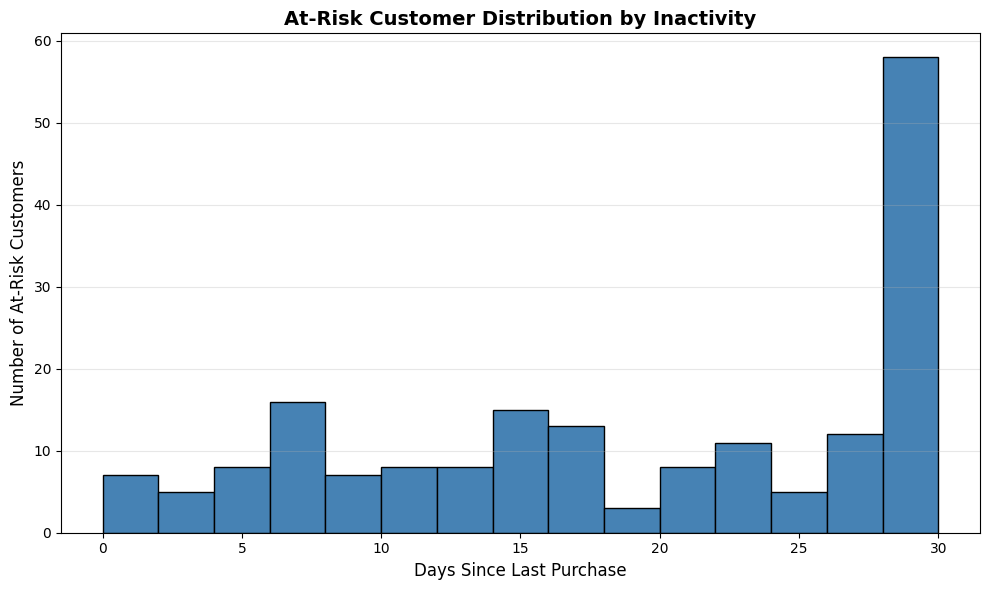

In [11]:
# Chart A: At-Risk Trend - Days Since Purchase Distribution
plt.figure(figsize=(10, 6))
plt.hist(at_risk_customers['days_since_purchase'], bins=15, edgecolor='black', color='steelblue')
plt.xlabel('Days Since Last Purchase', fontsize=12)
plt.ylabel('Number of At-Risk Customers', fontsize=12)
plt.title('At-Risk Customer Distribution by Inactivity', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

chart_a_path = '../output/charts/at_risk_days_since_purchase.png'
plt.savefig(chart_a_path, dpi=300, bbox_inches='tight')
print(f"✓ Chart A saved: {chart_a_path}")
plt.show()

✓ Chart B saved: ../output/charts/abandon_rate_by_tier.png


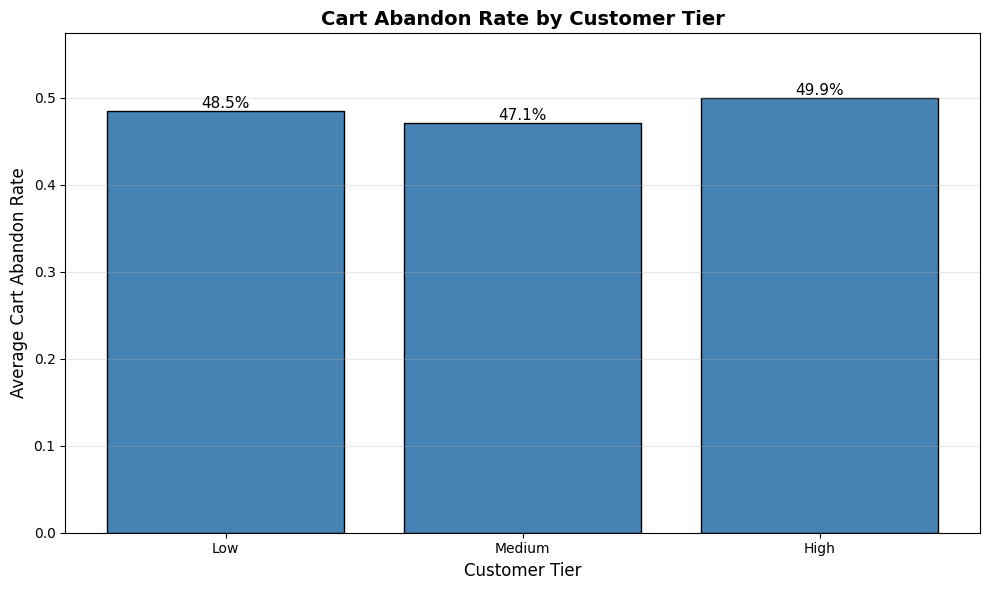

In [9]:
# Chart B: Abandon Rate by Tier
tier_chart_data = kpi_by_tier.copy()

plt.figure(figsize=(10, 6))
bars = plt.bar(tier_chart_data['customer_tier'], 
               tier_chart_data['avg_cart_abandon_rate'], 
               edgecolor='black', 
               color='steelblue')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom', fontsize=11)

plt.xlabel('Customer Tier', fontsize=12)
plt.ylabel('Average Cart Abandon Rate', fontsize=12)
plt.title('Cart Abandon Rate by Customer Tier', fontsize=14, fontweight='bold')
plt.ylim(0, max(tier_chart_data['avg_cart_abandon_rate']) * 1.15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

chart_b_path = '../output/charts/abandon_rate_by_tier.png'
plt.savefig(chart_b_path, dpi=300, bbox_inches='tight')
print(f"✓ Chart B saved: {chart_b_path}")
plt.show()

## Case Study Complete

This notebook is a production-ready script:
- **Location**: `scripts/generate_customer_health_report.py`
- **Purpose**: Automated weekly/monthly customer health reporting
- **Outputs**: 
  - KPI tables (overall, by country, by tier)
  - At-risk customer list
  - Executive charts

**To run the report:**
```bash
python scripts/generate_customer_health_report.py
```

All outputs are saved to the `output/` directory and can be:
- Emailed to stakeholders
- Dropped into presentations
- Scheduled via cron/Task Scheduler for automated execution